Population input (rows): 16


,year,population
0,2010,255000
1,2011,267000
2,2012,279000
3,2013,293000
4,2014,307000


Scenarios used: ['Low', 'Medium', 'High']


,year,population,demand_m3yr_Low,demand_m3day_Low,demand_m3yr_Medium,demand_m3day_Medium,demand_m3yr_High,demand_m3day_High
0,2010,255000,3723000.0,10200.0,5584500.0,15300.0,7446000.0,20400.0
1,2011,267000,3898200.0,10680.0,5847300.0,16020.0,7796400.0,21360.0
2,2012,279000,4073400.0,11160.0,6110100.0,16740.0,8146800.0,22320.0
3,2013,293000,4277800.0,11720.0,6416700.0,17580.0,8555600.0,23440.0
4,2014,307000,4482200.0,12280.0,6723300.0,18420.0,8964400.0,24560.0


📁 Saved chart: ../5_communication/charts\historical_population_and_demands.png


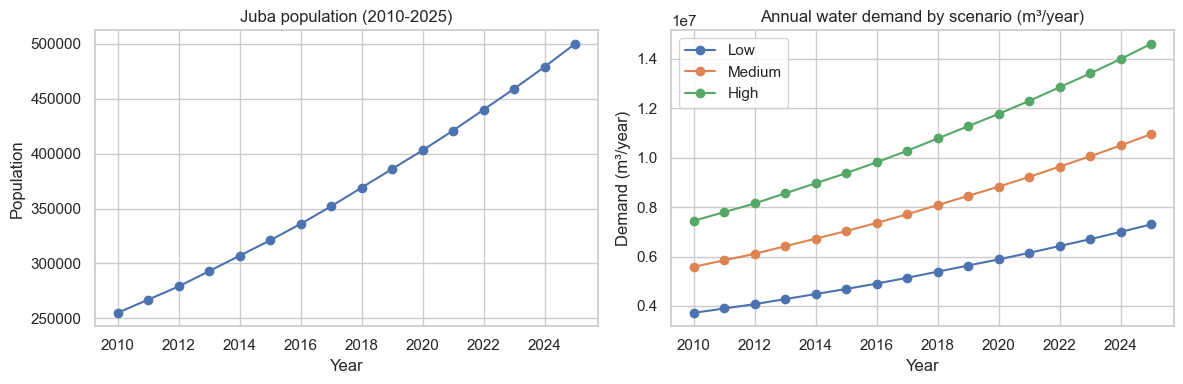


Scenario: Low
📁 Saved chart: ../5_communication/charts\forecast_Low.png


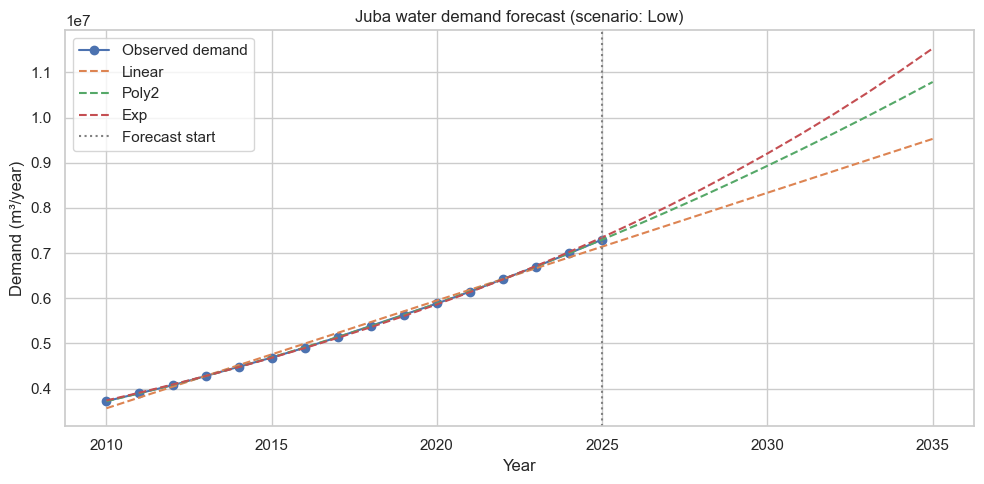

Saved forecast CSV: ./notebook4_outputs\forecast_Low.csv

Scenario: Medium
📁 Saved chart: ../5_communication/charts\forecast_Medium.png


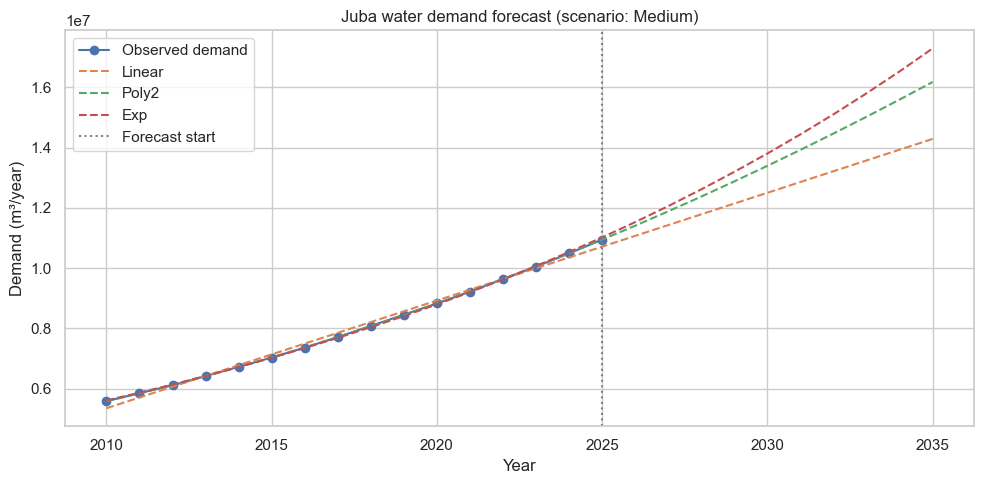

Saved forecast CSV: ./notebook4_outputs\forecast_Medium.csv

Scenario: High
📁 Saved chart: ../5_communication/charts\forecast_High.png


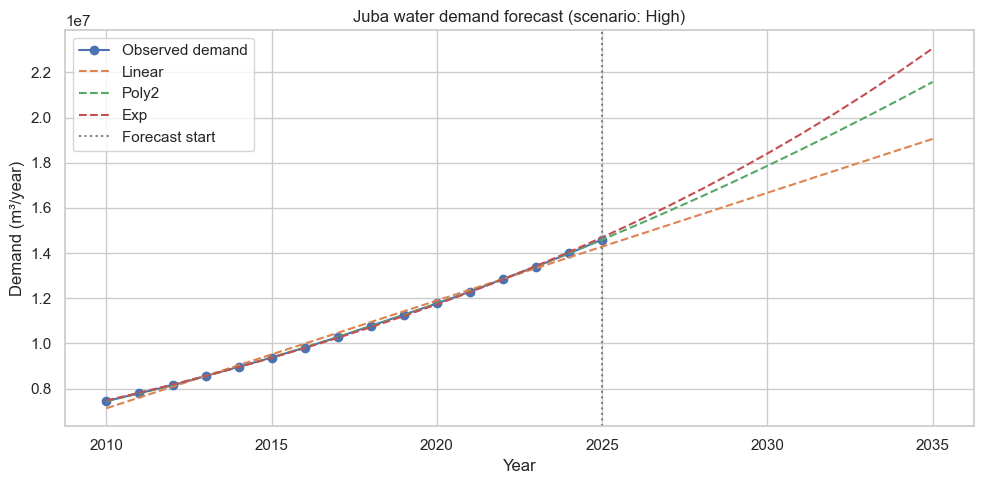

Saved forecast CSV: ./notebook4_outputs\forecast_High.csv

Scenario summary (selected horizons):


,scenario,year,linear,poly2,exp
0,Low,2030,8.335097e+06,8.931711e+06,9.204316e+06
1,Low,2035,9.527681e+06,1.078720e+07,1.153059e+07
2,Medium,2030,1.250265e+07,1.339757e+07,1.380647e+07
3,Medium,2035,1.429152e+07,1.618080e+07,1.729588e+07
4,High,2030,1.667019e+07,1.786342e+07,1.840863e+07
5,High,2035,1.905536e+07,2.157440e+07,2.306118e+07



Notebook 4 completed. Outputs in: ./notebook4_outputs


In [2]:
# ============================================================
# Notebook 4 — Forecasting Juba Water Demand (Population-based)
# Years: 2010-2025 observed, forecasts to 2035 (configurable)
# ============================================================

# ---------------------------
# IMPORTS
# ---------------------------
import os
import math
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Try statsmodels for ARIMA
try:
    from statsmodels.tsa.arima.model import ARIMA

    STATS_OK = True
except Exception:
    STATS_OK = False

# Try prophet (optional)
try:
    from prophet import Prophet

    PROPHET_OK = True
except Exception:
    PROPHET_OK = False

# ============================================================
# UNIVERSAL CHART SAVING FUNCTION
# Saves all charts to: 5_communication/charts/
# ============================================================
CHART_DIR = "../5_communication/charts"
os.makedirs(CHART_DIR, exist_ok=True)


def save_fig(name, fig=None, dpi=150):
    """Save any Matplotlib figure to the charts directory."""
    if fig is None:
        fig = plt.gcf()
    path = os.path.join(CHART_DIR, f"{name}.png")
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"📁 Saved chart: {path}")


# ---------------------------
# CONFIG
# ---------------------------
RANDOM_STATE = 42
OUT_DIR = "./notebook4_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Years to forecast until
FORECAST_YEAR_MAX = 2035

# Per-capita baseline scenarios (litres per person per day)
SCENARIOS = {"Low": 40.0, "Medium": 60.0, "High": 80.0}
# If you have a survey-based mean (L/person/day), set SURVEY_MEAN_LPPD to that value;
# otherwise leave as None to skip the survey-based scenario.
SURVEY_MEAN_LPPD = None  # e.g., 55.2

# Units:
# - Per-capita liters/person/day → convert to cubic meters per year as:
#   m3_per_year = liters_per_person_per_day * population * 365 / 1000

# ---------------------------
# INPUT: Juba population 2010-2025
# You provided the following series; we build a dataframe from it.
# Replace this block to load from CSV if you prefer.
# ---------------------------
pop_dict = {
    2010: 255000,
    2011: 267000,
    2012: 279000,
    2013: 293000,
    2014: 307000,
    2015: 321000,
    2016: 336000,
    2017: 352000,
    2018: 369000,
    2019: 386000,
    2020: 403000,
    2021: 421000,
    2022: 440000,
    2023: 459000,
    2024: 479000,
    2025: 500000,
}
pop_df = pd.DataFrame(
    {"year": list(pop_dict.keys()), "population": list(pop_dict.values())}
)
pop_df = pop_df.sort_values("year").reset_index(drop=True)
print("Population input (rows):", pop_df.shape[0])
display(pop_df.head())


# ---------------------------
# Helper functions
# ---------------------------
def lppd_to_annual_m3(population, lppd):
    """Convert liters/person/day and population to cubic meters per year."""
    # liters/day * pop * 365 days / 1000 = cubic meters per year
    return (lppd * population * 365.0) / 1000.0


def evaluate_forecast(true, pred):
    """Return RMSE and MAPE; handle zeros for MAPE."""
    rmse = math.sqrt(mean_squared_error(true, pred))
    try:
        mape = mean_absolute_percentage_error(true, pred)
    except Exception:
        # fallback if true contains zeros -> compute safe MAPE
        denom = np.where(true == 0, np.nan, true)
        mape = np.nanmean(np.abs((pred - true) / denom))
    return rmse, mape


# ---------------------------
# Build historical demand table for scenarios
# ---------------------------
years_obs = pop_df["year"].values
years_all = np.arange(pop_df["year"].min(), FORECAST_YEAR_MAX + 1)

# Add survey scenario if SURVEY_MEAN_LPPD provided
scenarios = SCENARIOS.copy()
if SURVEY_MEAN_LPPD is not None:
    scenarios["Survey"] = SURVEY_MEAN_LPPD

# Compute historical annual demand for each scenario
hist_demands = []
for name, lppd in scenarios.items():
    pop_df[f"demand_m3yr_{name}"] = pop_df["population"].apply(
        lambda p: lppd_to_annual_m3(p, lppd)
    )
    pop_df[f"demand_m3day_{name}"] = pop_df["population"].apply(
        lambda p: (lppd * p) / 1000.0
    )  # m3/day
    hist_demands.append(name)

print("Scenarios used:", list(scenarios.keys()))
display(pop_df.head())

# Save historical table
pop_df.to_csv(os.path.join(OUT_DIR, "juba_population_and_scenarios.csv"), index=False)

# ---------------------------
# Plot historical population and demands
# ---------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(pop_df["year"], pop_df["population"], marker="o")
ax[0].set_title("Juba population (2010-2025)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Population")

for name in scenarios.keys():
    ax[1].plot(pop_df["year"], pop_df[f"demand_m3yr_{name}"], marker="o", label=name)
ax[1].set_title("Annual water demand by scenario (m³/year)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Demand (m³/year)")
ax[1].legend()
plt.tight_layout()
save_fig("historical_population_and_demands", fig)
plt.show()

# ---------------------------
# Forecast models (we forecast demand in m3/year)
# We'll train on observed years and then predict until FORECAST_YEAR_MAX.
# We'll show results for each scenario separately.
# ---------------------------
results = {}
for scenario_name in scenarios.keys():
    print("\n" + "=" * 40)
    print("Scenario:", scenario_name)
    print("=" * 40)

    # Prepare training data
    df_s = (
        pop_df[["year", "population", f"demand_m3yr_{scenario_name}"]]
        .copy()
        .reset_index(drop=True)
    )
    df_s = df_s.rename(columns={f"demand_m3yr_{scenario_name}": "demand_m3yr"})
    # X as year numeric (reshape for sklearn)
    X = df_s["year"].values.reshape(-1, 1)
    y = df_s["demand_m3yr"].values

    # Make forecast index
    future_years = np.arange(df_s["year"].min(), FORECAST_YEAR_MAX + 1)
    X_future = future_years.reshape(-1, 1)

    # ---- Linear Regression ----
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred_lr = lr.predict(X)
    y_fore_lr = lr.predict(X_future)

    rmse_lr, mape_lr = evaluate_forecast(y, y_pred_lr)

    # ---- Polynomial degree=2 ----
    poly = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False), LinearRegression()
    )
    poly.fit(X, y)
    y_pred_poly = poly.predict(X)
    y_fore_poly = poly.predict(X_future)
    rmse_poly, mape_poly = evaluate_forecast(y, y_pred_poly)

    # ---- Exponential (log-linear) ----
    # Fit log(y) = a + b*year  => y = exp(a + b*year)
    # only valid if y>0
    if np.all(y > 0):
        ly = np.log(y)
        lr_log = LinearRegression()
        lr_log.fit(X, ly)
        ly_pred = lr_log.predict(X)
        y_pred_exp = np.exp(ly_pred)
        ly_fore = lr_log.predict(X_future)
        y_fore_exp = np.exp(ly_fore)
        rmse_exp, mape_exp = evaluate_forecast(y, y_pred_exp)
    else:
        y_pred_exp = np.full_like(y, np.nan)
        y_fore_exp = np.full_like(X_future.flatten(), np.nan)
        rmse_exp, mape_exp = np.nan, np.nan

    # ---- ARIMA (if available) ----
    arima_res = None
    y_fore_arima = None
    rmse_arima, mape_arima = np.nan, np.nan
    if STATS_OK:
        # Build a simple ARIMA on demand series (order selected by AIC brute force small grid)
        try:
            # use small grid for speed
            best_aic = np.inf
            best_order = None
            best_model = None
            for p in range(0, 3):
                for d in range(0, 2):
                    for q in range(0, 3):
                        try:
                            model = ARIMA(y, order=(p, d, q))
                            fit = model.fit()
                            if fit.aic < best_aic:
                                best_aic = fit.aic
                                best_order = (p, d, q)
                                best_model = fit
                        except Exception:
                            continue
            if best_model is not None:
                arima_res = best_model
                # forecast for future_years length
                steps = len(future_years) - len(
                    X
                )  # forecast horizon beyond training end
                # to build full series, we will produce in-sample fitted + forecast
                y_in_sample = arima_res.fittedvalues
                # For consistent indexing, directly forecast out to last future year from end of training
                forecast_out = arima_res.get_forecast(steps=len(future_years) - len(X))
                fore_mean = np.concatenate([y_in_sample, forecast_out.predicted_mean])
                # Compose full future vector aligned to X_future
                # We'll simply take forecast starting from training start for plotting comparability:
                y_fore_arima = np.concatenate(
                    [y_in_sample, forecast_out.predicted_mean]
                )
                # Compute rmse/mape on in-sample fitted
                rmse_arima, mape_arima = evaluate_forecast(y, y_in_sample)
        except Exception as e:
            print("ARIMA failed:", e)
            arima_res = None

    # ---- Prophet (optional) ----
    y_fore_prophet = None
    rmse_prophet, mape_prophet = np.nan, np.nan
    if PROPHET_OK:
        try:
            df_prop = pd.DataFrame(
                {
                    "ds": pd.to_datetime(
                        df_s["year"].astype(int).astype(str) + "-01-01"
                    ),
                    "y": df_s["demand_m3yr"].values,
                }
            )
            m = Prophet()
            m.fit(df_prop)
            future = pd.DataFrame(
                {"ds": pd.to_datetime(future_years.astype(str) + "-01-01")}
            )
            fcst = m.predict(future)
            y_fore_prophet = fcst["yhat"].values
            # Evaluate on training period (first len(X) entries)
            y_pred_prophet_train = y_fore_prophet[: len(X)]
            rmse_prophet, mape_prophet = evaluate_forecast(y, y_pred_prophet_train)
        except Exception as e:
            print("Prophet failed:", e)
            y_fore_prophet = None

    # ---- Collect results ----
    df_fore = pd.DataFrame(
        {
            "year": future_years,
            "pop": np.interp(
                future_years, pop_df["year"], pop_df["population"]
            ),  # linear interpolation for pop beyond 2025
            "pred_lr": y_fore_lr,
            "pred_poly": y_fore_poly,
            "pred_exp": y_fore_exp if np.all(y > 0) else np.nan,
        }
    )
    if y_fore_arima is not None:
        # align lengths: y_fore_arima may be length training + horizon; pad/trim to future_years
        # We'll create pred_arima as best available: fitted in-sample then forecast
        # If y_fore_arima shorter than future_years, pad with NaN
        arr = np.full_like(df_fore["pred_lr"].values, np.nan, dtype=float)
        n = len(y_fore_arima)
        arr[:n] = y_fore_arima
        df_fore["pred_arima"] = arr
    else:
        df_fore["pred_arima"] = np.nan

    if y_fore_prophet is not None:
        df_fore["pred_prophet"] = y_fore_prophet
    else:
        df_fore["pred_prophet"] = np.nan

    # Save summary metrics
    metrics = {
        "linear": {"rmse": rmse_lr, "mape": mape_lr},
        "poly2": {"rmse": rmse_poly, "mape": mape_poly},
        "exp": {"rmse": rmse_exp, "mape": mape_exp},
        "arima": {"rmse": rmse_arima, "mape": mape_arima},
        "prophet": {"rmse": rmse_prophet, "mape": mape_prophet},
    }

    results[scenario_name] = {
        "model_linear": lr,
        "model_poly2": poly,
        "model_logexp": lr_log if np.all(y > 0) else None,
        "arima_fit": arima_res,
        "prophet_fit": None if not PROPHET_OK else None,
        "df_forecast": df_fore,
        "metrics": metrics,
    }

    # ---- Plot forecasts (comparison) ----
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(df_s["year"], df_s["demand_m3yr"], "o-", label="Observed demand")
    ax.plot(df_fore["year"], df_fore["pred_lr"], "--", label="Linear")
    ax.plot(df_fore["year"], df_fore["pred_poly"], "--", label="Poly2")
    if np.all(y > 0):
        ax.plot(df_fore["year"], df_fore["pred_exp"], "--", label="Exp")
    if df_fore["pred_arima"].notna().any():
        ax.plot(df_fore["year"], df_fore["pred_arima"], "--", label="ARIMA")
    if PROPHET_OK and df_fore["pred_prophet"].notna().any():
        ax.plot(df_fore["year"], df_fore["pred_prophet"], "--", label="Prophet")
    ax.axvline(df_s["year"].max(), color="grey", linestyle=":", label="Forecast start")
    ax.set_title(f"Juba water demand forecast (scenario: {scenario_name})")
    ax.set_xlabel("Year")
    ax.set_ylabel("Demand (m³/year)")
    ax.legend()
    plt.tight_layout()
    save_fig(f"forecast_{scenario_name}", fig)
    plt.show()

    # Save forecast CSV for this scenario
    fname = os.path.join(OUT_DIR, f"forecast_{scenario_name}.csv")
    df_fore.to_csv(fname, index=False)
    print("Saved forecast CSV:", fname)

# ---------------------------
# Scenario comparison at horizons (2030, 2035)
# ---------------------------
summary_rows = []
for scen, out in results.items():
    df_f = out["df_forecast"]
    for y in [2030, 2035]:
        if y in df_f["year"].values:
            row = {
                "scenario": scen,
                "year": y,
                "linear": float(df_f.loc[df_f["year"] == y, "pred_lr"].values[0]),
                "poly2": float(df_f.loc[df_f["year"] == y, "pred_poly"].values[0]),
                "exp": float(df_f.loc[df_f["year"] == y, "pred_exp"].values[0])
                if "pred_exp" in df_f.columns
                else np.nan,
            }
            summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\nScenario summary (selected horizons):")
display(summary_df)

summary_df.to_csv(os.path.join(OUT_DIR, "scenario_summary_horizons.csv"), index=False)

# ---------------------------
# Save final metadata & metrics
# ---------------------------
meta = {
    "generated_at": datetime.utcnow().isoformat(),
    "forecast_horizon_end": FORECAST_YEAR_MAX,
    "scenarios": list(scenarios.keys()),
}
pd.DataFrame([meta]).to_csv(os.path.join(OUT_DIR, "forecast_metadata.csv"), index=False)
print("\nNotebook 4 completed. Outputs in:", OUT_DIR)